# 過去も未来も星座も超えるスペースコロニーXR 体験、君を街ごと宇宙世紀に連れてゆく

## テクスチャ生成

In [35]:
import folium;from pyppeteer import launch;from PIL import Image;import numpy as np;
import matplotlib.pyplot as plt;import os;import nest_asyncio;import cv2;import asyncio;

nest_asyncio.apply() # jupyter環境でのイベントループ競合対策
lat = 34.98686175788536;lon = 135.75880365485335 # 中心緯度経度を設定（京都の例）
ratio=100 # 1kmが緯度・経度の何分の1に相当するか（日本では、経度・経度ともに１°あたり約100km）
# 直径6.4km・長さ32km内の陸地
lat_delta=32/ratio; lon_delta=2*np.pi*(6.4/2)/3/2/ratio;lon_space=lon_delta/10
map_object = folium.Map( # folium 地図を作成
    min_lat=lat-1.5*lat_delta, max_lat=lat+1.5*lat_delta,
    min_lon=lon-lon_delta/2, max_lon=lon+lon_delta/2,
    zoom_control = False, control_scale=False, max_bounds=True,
    tiles='https://cyberjapandata.gsi.go.jp/xyz/ort/{z}/{x}/{y}.jpg',
    attr="電子国土基本図（オルソ画像）")
map_object.fit_bounds([[lat-lat_delta/2, lon-3*lon_delta/2],
                       [lat+lat_delta/2, lon+3*lon_delta/2]])
for i, color in enumerate(['#400000','#004000','#000040']): # 陸地を3つ矩形で描く
    folium.Rectangle(bounds=[
        [lat-lat_delta/2, lon+(i-1)*(lon_delta+lon_space)],
        [lat+lat_delta/2, lon+(i-1)*(lon_delta+lon_space)+lon_delta]],
                 color=color, fill=False).add_to(map_object)
map_file = "map.html";map_object.save(map_file) # folium地図をHTMLファイルに保存
async def capture_screenshot(): # ブラウザ画面を取得する非同期関数
    browser = await launch(
        headless="new", # ブラウザを表示しない（表示時はFalse）
        args=["--disable-gpu", '--disable-web-security', # CORS無効化
        '--allow-file-access-from-files'])  # ローカルファイルアクセス許可
    page = await browser.newPage() # ブラウザを起動する
    await page.setViewport({"width":1800, "height":1800}) # ブラウザサイズ
    await page.goto(f"file://{os.path.abspath('.')}/map.html")
    await asyncio.sleep(10)  # ページ読み込み用に待ち時間を入れる
    screenshot_file = "map_screenshot.png"
    await page.screenshot({"path": screenshot_file}) # 画面をファイルに保存
    await asyncio.sleep(1); await browser.close();return screenshot_file
loop = asyncio.get_event_loop() # ブラウザ画面を取得する非同期関数を実行
screenshot_file = loop.run_until_complete(capture_screenshot())

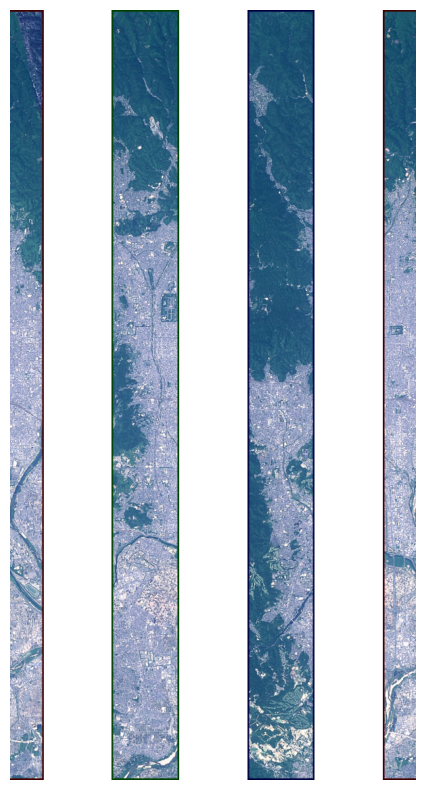

In [36]:
def extract_colored_rectangles(image, color_values):
    extracted_images = []
    for color in color_values:
        mask = cv2.inRange(image, color-1, color+1)
        contours, _=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x,y,w,h= cv2.boundingRect(cnt);extracted_images.append(image[y:y+h,x:x+w])
    return extracted_images
input_image = cv2.imread(screenshot_file) # PNG画像の読み込み
color_values = [np.array([0,0,64]),np.array([64,0,0]),np.array([0,64,0])]
extracted_images = extract_colored_rectangles(input_image, color_values)
output_image = 255*np.ones(( # 白画素背景のテクスチャ用画像を作成
    np.amax([im.shape[0] for im in extracted_images]),
    3*2*np.amax([im.shape[1] for im in extracted_images]),3), dtype=np.uint8)
offset_x = 2*np.amax([im.shape[1] for im in extracted_images])
for idx, img in enumerate(extracted_images): # 陸地テクスチャを貼り付け
    h,w=img.shape[:2]; output_image[0:h,idx*offset_x:idx*offset_x+w]=img
output_image = np.roll(output_image, shift=(0, -int(offset_x/4)), axis=(0, 1))
# RGB形式に変換し、アルファチャンネル追加した上で、白色の部分を透明にする。また、南北反転もする
img_rgb = cv2.flip(cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB),1)
img_rgba = np.dstack((img_rgb, np.ones(img_rgb.shape[:2], dtype=np.uint8) * 255))
white_pixels = (img_rgb == [255, 255, 255]).all(axis=-1)
img_rgba[white_pixels,3]=0;Image.fromarray(img_rgba).save('texture_colony_back.png',"PNG")
plt.figure(figsize=(10,10));plt.imshow(img_rgb);plt.axis("off");plt.show() # 画像表示

## A-Frameのオブジェクト追加

In [40]:
# 3枚の翼と農業用リングを追加

from bs4 import BeautifulSoup; import math
with open("xr_template.htm", "r", encoding="utf-8") as file: # HTMLファイルを読み込み
    soup = BeautifulSoup(file, "html.parser")
a_scene = soup.find("a-scene") 
if a_scene: # a-sceneタグを見つけたら、オブジェクトを追加する
    for i in range(3): # 鏡を備えた翼を追加
        outer_plane=soup.new_tag("a-plane",rotation=f"0 0 {i*120}")
        inner_plane=soup.new_tag("a-plane",height="1700",width="325",
        rotation="45 0 0",position="0 890 -860",side="double",
        material="src: #mirrorTexture;emissive:#404040;emissiveIntensity:0.7")
        outer_plane.append(inner_plane); a_scene.append(outer_plane)
    for i in range(100): # 農業用リングを追加
        a_sphere=soup.new_tag("a-sphere",radius="50",color="#F0F0F0",
            position=
            f"{1500*math.cos(i/100*2*math.pi)} {1500*math.sin(i/100*2*math.pi)} 1200")
        a_scene.append(a_sphere)
with open("xr.htm", "w", encoding="utf-8") as file: # 更新されたHTMLを保存
    file.write(str(soup))

## httpsサーバ起動(Flask版)

In [ ]:
from flask import Flask, render_template
app = Flask(__name__, static_folder='.', static_url_path='')
@app.route('/') # デコレートしてTop処理を定義
def index():
    return render_template('index.htm')
app.run(host='0.0.0.0',port=443,ssl_context=('./cert.pem','./key.pem'))

## 尾道の小領域からテクスチャ生成する例

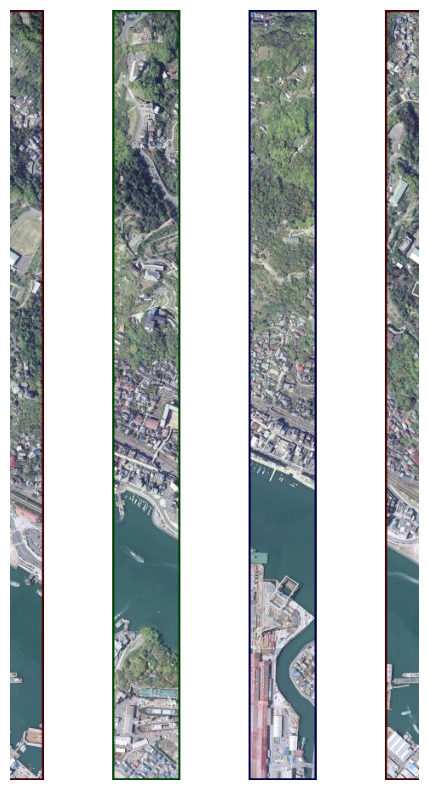

In [33]:
import folium;from pyppeteer import launch;from PIL import Image;import numpy as np;
import matplotlib.pyplot as plt;import os;import nest_asyncio;import cv2;import asyncio;

nest_asyncio.apply() # jupyter環境でのイベントループ競合対策
lat = 34.40734340318606;lon = 133.19512024987176 # 中心緯度経度を設定（京都の例）
ratio=2000 # 1kmが緯度・経度の何分の1に相当するか（日本では、経度・経度ともに１°あたり約100km）
# 直径6.4km・長さ32km内の陸地
lat_delta=32/ratio; lon_delta=2*np.pi*(6.4/2)/3/2/ratio;lon_space=lon_delta/10
map_object = folium.Map( # folium 地図を作成
    min_lat=lat-1.5*lat_delta, max_lat=lat+1.5*lat_delta,
    min_lon=lon-lon_delta/2, max_lon=lon+lon_delta/2,
    zoom_control = False, control_scale=False, max_bounds=True,
    tiles='https://cyberjapandata.gsi.go.jp/xyz/ort/{z}/{x}/{y}.jpg',
    attr="電子国土基本図（オルソ画像）")
map_object.fit_bounds([[lat-lat_delta/2, lon-3*lon_delta/2],
                       [lat+lat_delta/2, lon+3*lon_delta/2]])
for i, color in enumerate(['#400000','#004000','#000040']): # 陸地を3つ矩形で描く
    folium.Rectangle(bounds=[
        [lat-lat_delta/2, lon+(i-1)*(lon_delta+lon_space)],
        [lat+lat_delta/2, lon+(i-1)*(lon_delta+lon_space)+lon_delta]],
                 color=color, fill=False).add_to(map_object)
map_file = "map.html";map_object.save(map_file) # folium地図をHTMLファイルに保存

async def capture_screenshot(): # ブラウザ画面を取得する非同期関数
    browser = await launch(
        headless="new", # ブラウザを表示しない（表示時はFalse）
        args=["--disable-gpu", '--disable-web-security', # CORS無効化
        '--allow-file-access-from-files'])  # ローカルファイルアクセス許可
    page = await browser.newPage() # ブラウザを起動する
    await page.setViewport({"width":1800, "height":1800}) # ブラウザサイズ
    await page.goto(f"file://{os.path.abspath('.')}/map.html")
    await asyncio.sleep(10)  # ページ読み込み用に待ち時間を入れる
    screenshot_file = "map_screenshot.png"
    await page.screenshot({"path": screenshot_file}) # 画面をファイルに保存
    await asyncio.sleep(1); await browser.close();return screenshot_file
loop = asyncio.get_event_loop() # ブラウザ画面を取得する非同期関数を実行
screenshot_file = loop.run_until_complete(capture_screenshot())

def extract_colored_rectangles(image, color_values):
    extracted_images = []
    for color in color_values:
        mask = cv2.inRange(image, color-1, color+1)
        contours, _=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x,y,w,h= cv2.boundingRect(cnt);extracted_images.append(image[y:y+h,x:x+w])
    return extracted_images

input_image = cv2.imread(screenshot_file) # PNG画像の読み込み
color_values = [np.array([0,0,64]),np.array([64,0,0]),np.array([0,64,0])]
extracted_images = extract_colored_rectangles(input_image, color_values)
output_image = 255*np.ones(( # 白画素背景のテクスチャ用画像を作成
    np.amax([im.shape[0] for im in extracted_images]),
    3*2*np.amax([im.shape[1] for im in extracted_images]),3), dtype=np.uint8)
offset_x = 2*np.amax([im.shape[1] for im in extracted_images])
for idx, img in enumerate(extracted_images): # 陸地テクスチャを貼り付け
    h,w=img.shape[:2]; output_image[0:h,idx*offset_x:idx*offset_x+w]=img
output_image = np.roll(output_image, shift=(0, -int(offset_x/4)), axis=(0, 1))
# RGB形式に変換し、アルファチャンネル追加した上で、白色の部分を透明にする。また、南北反転もする
img_rgb = cv2.flip(cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB),1)
img_rgba = np.dstack((img_rgb, np.ones(img_rgb.shape[:2], dtype=np.uint8) * 255))
white_pixels = (img_rgb == [255, 255, 255]).all(axis=-1)
img_rgba[white_pixels,3]=0;Image.fromarray(img_rgba).save('texture_colony_back_onomich_scale10.png',"PNG")
plt.figure(figsize=(10,10));plt.imshow(img_rgb);plt.axis("off");plt.show() # 画像表示